### Import Modules

In [21]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

### Load Model

In [22]:
model = YOLO("yolov8s.pt")  # Load the YOLOv8 model
model.fuse()

100%|██████████| 21.5M/21.5M [00:02<00:00, 8.22MB/s]


YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [23]:
class_names = model.model.names  # Get class names from the model

#class_names 

In [24]:
#select class id's needed
classes = [2, 3, 5, 7]

### Plot frame from video

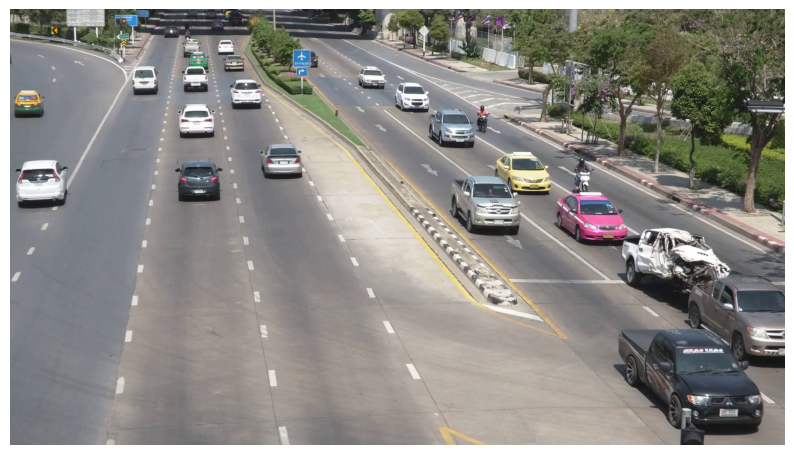

In [25]:
#create a frame generator
generator = sv.get_video_frames_generator('test1.mp4')

iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

### Detect Vehicles from Frame

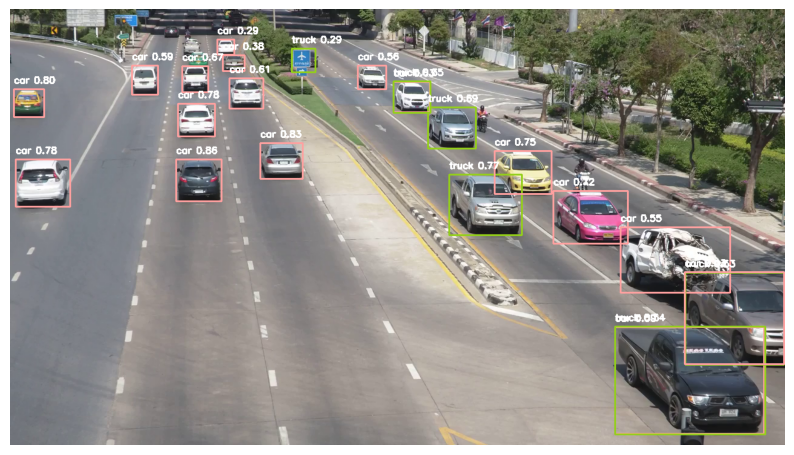

In [26]:
results = model(frame, verbose=False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)

#only consider classes we need
detections = detections[np.isin(detections.class_id, classes)]

#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#annotate the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

#format and get labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{class_names[class_id]} {confidence:0.2f}"
    labels.append(label)

#overlay labels in bounding box
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    #display the text
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

sv.plot_image(annotated_frame, (10, 10))

### Track Vehicles

In [27]:
sv.VideoInfo.from_video_path('test1.mp4')

VideoInfo(width=1280, height=720, fps=29, total_frames=2418)

In [28]:
#create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=29)

#create trace annotator
trace_annotator = sv.TraceAnnotator(
    thickness=2,
    trace_length=75
)

In [29]:
#define function for processing frames
def process_frame(frame):
    results = model(frame, verbose=False)[0]

    #convert to detections
    detections = sv.Detections.from_ultralytics(results)

    #only consider classes we need
    detections = detections[np.isin(detections.class_id, classes)]

    #tracking detection
    detections = byte_tracker.update_with_detections(detections)

    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f"{tracker_id} {class_names[class_id]} {confidence:0.2f}"
        labels.append(label)

    #update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

    #uodate box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    #overlay labels in bounding box
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        #display the text
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return annotated_frame
    

In [30]:
# Realtime output using cv2 window
video_path = 'test1.mp4'
video_cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not video_cap.isOpened():
    print("Error: Could not open video file")
    exit()

frame_count = 0
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

try:
    print(f"Processing {total_frames} frames...")
    while True:
        success, frame = video_cap.read()
        if not success:
            break
        frame_count += 1
        # Resize frame
        frame = cv2.resize(frame, (1280, 720))
        # Process frame
        processed_frame = process_frame(frame)
        # Convert to BGR for display
        processed_frame_bgr = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)
        # Show frame in window
        cv2.imshow('Realtime Detection', processed_frame_bgr)
        # Exit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print('Exit requested by user.')
            break
        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    video_cap.release()
    cv2.destroyAllWindows()
    print(f"Realtime video processing completed. Processed {frame_count} frames total.")

Processing 2418 frames...
Progress: 30/2418 frames (1.2%)
Progress: 60/2418 frames (2.5%)
Progress: 90/2418 frames (3.7%)
Progress: 120/2418 frames (5.0%)
Progress: 150/2418 frames (6.2%)
Progress: 180/2418 frames (7.4%)
Progress: 210/2418 frames (8.7%)
Progress: 240/2418 frames (9.9%)
Progress: 270/2418 frames (11.2%)
Progress: 300/2418 frames (12.4%)
Progress: 330/2418 frames (13.6%)
Progress: 360/2418 frames (14.9%)
Progress: 390/2418 frames (16.1%)
Progress: 420/2418 frames (17.4%)
Progress: 450/2418 frames (18.6%)
Progress: 480/2418 frames (19.9%)
Progress: 510/2418 frames (21.1%)
Progress: 540/2418 frames (22.3%)
Progress: 570/2418 frames (23.6%)
Progress: 600/2418 frames (24.8%)
Progress: 630/2418 frames (26.1%)
Progress: 660/2418 frames (27.3%)
Exit requested by user.
Realtime video processing completed. Processed 670 frames total.
